# Validation for XBB.1.5 DMS serum escape mutations

### Set up Analysis

In [1]:
import itertools
import math
import os
import re
import warnings

from IPython.display import display, HTML

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import natsort

import seaborn

import numpy as np
import pandas as pd
from plotnine import *

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE

import yaml
import altair as alt

plt.rcParams['svg.fonttype'] = 'none'

In [2]:
theme_set(theme_seaborn(style='white', context='talk', font_scale=1))
plt.style.use('seaborn-white')

/tmp/ipykernel_31770/2098504240.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


In [3]:
warnings.simplefilter('ignore')

Read config file.

In [4]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Set seaborn theme:

In [5]:
resultsdir=config['resultsdir']
os.makedirs(resultsdir, exist_ok=True)

## Read in data

In [6]:
frac_infect = pd.read_csv(config['serum_neuts'], index_col=0)

## Fit Hill curve to data using [`neutcurve`](https://jbloomlab.github.io/neutcurve/)

In [7]:
fits = neutcurve.CurveFits(frac_infect,  fixtop= False)

In [8]:
fitparams = (
        fits.fitParams(ics=[50,90])
        # get columns of interest
        [['serum', 'ic50', 'ic50_bound', 'ic90', 'virus']]
        .assign(NT50=lambda x: 1/x['ic50'], NT90=lambda x: 1/x['ic90'])        
        )

In [9]:
fitparams['ic50_is_bound'] = fitparams['ic50_bound'].apply(lambda x: True if x!='interpolated' else False)


In [10]:
fitparams.to_csv('results/NT50_table.csv',index=False)

## Plot escape for each sera for NTD mutations

Saving to NTD_mutation_serum_escape.svg


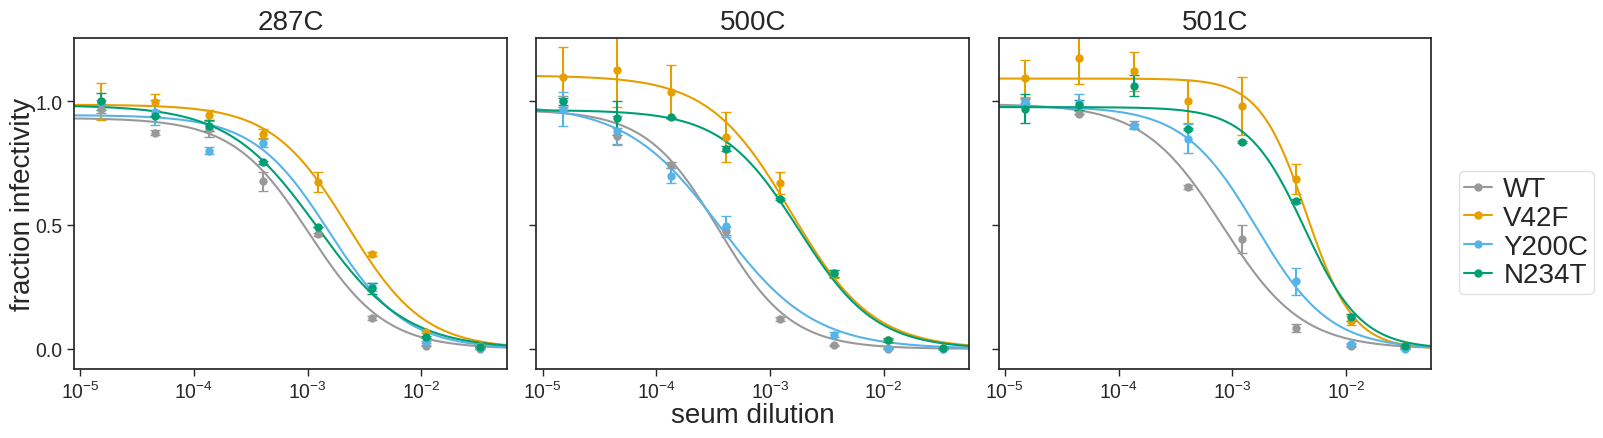

In [11]:
fig, axes = fits.plotSera(xlabel='seum dilution',
                          viruses = ['WT', 'V42F', 'Y200C', 'N234T'],
                          ncol=3,
                          widthscale=1.5,
                          heightscale=1.5,
                          titlesize=20, labelsize=20, ticksize=14,
                          legendfontsize=20, yticklocs=[0,0.5,1],
                          markersize=5, linewidth=1.5,
                          max_viruses_per_subplot = 8,
                          markers=['o','o','o','o']
                         )

plotfile = 'NTD_mutation_serum_escape.svg'
print(f"Saving to {plotfile}")
fig.savefig(f'{resultsdir}/{plotfile}', bbox_inches='tight')

## Plot escape for each sera for RBD mutations

Saving to RBD_mutation_serum_escape.svg


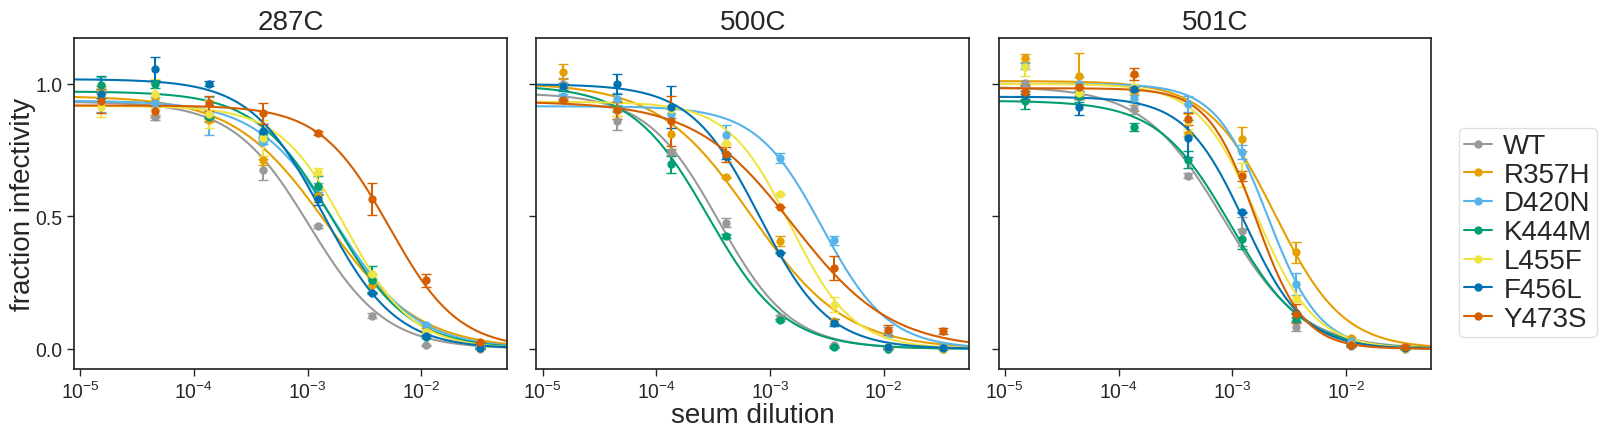

In [12]:
fig, axes = fits.plotSera(xlabel='seum dilution',
                          viruses = ['WT', 'R357H', 'D420N', 'K444M',
                                    'L455F','F456L','Y473S' ],
                          ncol=3,
                          widthscale=1.5,
                          heightscale=1.5,
                          titlesize=20, labelsize=20, ticksize=14,
                          legendfontsize=20, yticklocs=[0,0.5,1],
                          markersize=5, linewidth=1.5,
                          max_viruses_per_subplot = 7,
                          markers=['o','o','o','o','o','o','o']
                         )
plotfile = 'RBD_mutation_serum_escape.svg'
print(f"Saving to {plotfile}")
fig.savefig(f'{resultsdir}/{plotfile}', bbox_inches='tight')

## Plot escape for each sera for SD1 and S2 mutations

Saving to SD1_S2_mutation_serum_escape.svg


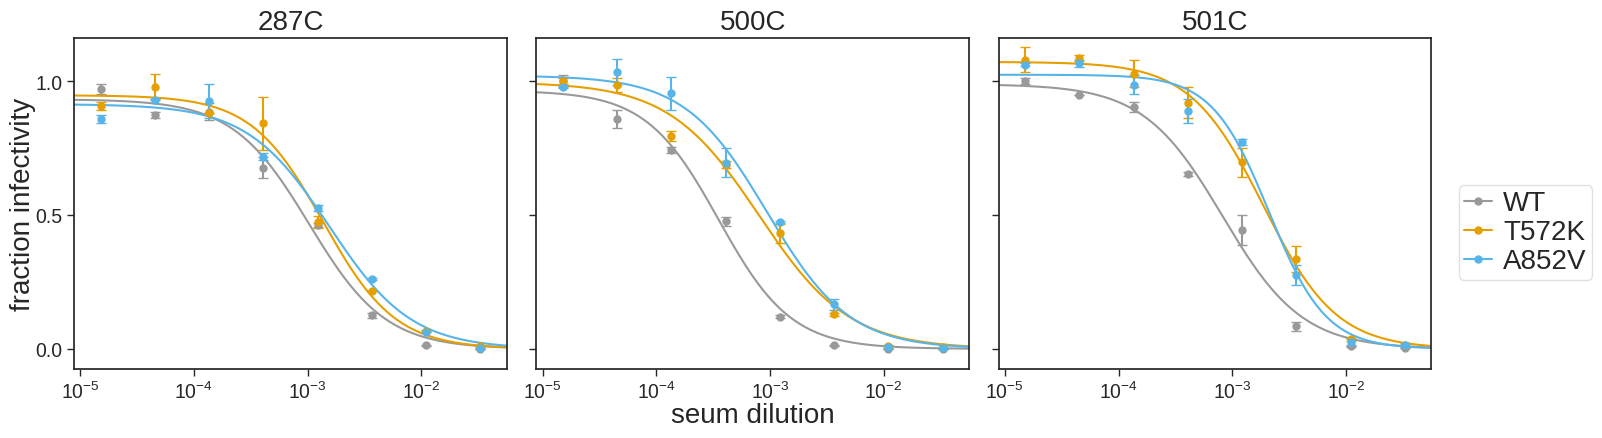

In [13]:
fig, axes = fits.plotSera(xlabel='seum dilution',
                          viruses = ['WT', 'T572K', 'A852V'],
                          ncol=3,
                          widthscale=1.5,
                          heightscale=1.5,
                          titlesize=20, labelsize=20, ticksize=14,
                          legendfontsize=20, yticklocs=[0,0.5,1],
                          markersize=5, linewidth=1.5,
                          max_viruses_per_subplot = 8,
                          markers=['o','o','o','o','o','o','o']
                         )
plotfile = 'SD1_S2_mutation_serum_escape.svg'
print(f"Saving to {plotfile}")
fig.savefig(f'{resultsdir}/{plotfile}', bbox_inches='tight')

## Compare neuts to DMS escape

In [14]:
dms_287C = config['dms_287C']

dms_287C = pd.read_csv(dms_287C).assign(
    sera="287C").drop(columns=['site', 'mutant'])
C287 = pd.merge(fitparams, dms_287C,  how='inner', left_on=['virus', 'serum'], right_on=['mutation', 'sera'])


In [15]:
dms_500C = config['dms_500C']

dms_500C = pd.read_csv(dms_500C).assign(
    sera="500C").drop(columns=["epitope", 'site', 'mutant'])
C500 = pd.merge(fitparams, dms_500C,  how='inner', left_on=['virus', 'serum'], right_on=['mutation', 'sera'])


In [16]:
dms_501C = config['dms_501C']

dms_501C = pd.read_csv(dms_501C).assign(
    sera="501C").drop(columns=["epitope", 'site', 'mutant'])
C501 = pd.merge(fitparams, dms_501C,  how='inner', left_on=['virus', 'serum'], right_on=['mutation', 'sera'])


In [17]:
#concatenate escape data
validation_vs_escape = pd.concat([C287, C500,C501], ignore_index=True)

In [18]:
# Define mapping
ntd_list = ['V42F', 'Y200C', 'N234T']
rbd_list = ['R403K', 'N405K', 'R357H', 'D420N', 'K444M', 'L455F', 'F456L', 'Y473S']
s2_list = ['A852V']
other_list = ['T572K']

# Apply mapping
def assign_region(virus_value):
    if virus_value in ntd_list:
        return 'NTD'
    elif virus_value in rbd_list:
        return 'RBD'
    elif virus_value in s2_list:
        return 'S2'
    elif virus_value in other_list:
        return 'other'
    else:
        return None

validation_vs_escape['region'] = validation_vs_escape['virus'].apply(assign_region)


In [19]:
new_rows = [
    {"serum": "287C", "escape_mean": 0, "ic90": 0.005333, "virus": "WT1", "region": "WT"},
    {"serum": "500C", "escape_mean": 0, "ic90": 0.001732, "virus": "WT1", "region": "WT"},
    {"serum": "501C", "escape_mean": 0, "ic90": 0.004808, "virus": "WT1", "region": "WT"}
     ]
     

# Append these rows to the validation_vs_escape dataframe
validation_vs_escape = validation_vs_escape.append(new_rows, ignore_index=True)

In [20]:
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8',
          '#f58231', '#911eb4', '#46f0f0', 
          '#bcf60c', '#fabebe', '#008080', 
          '#9a6324', '#800000', '#aaffc3',
          '#808000', '#ffd8b1', '#000075', '#808080'
]

In [21]:
# Extract unique serums and calculate correlations
serums = validation_vs_escape['serum'].unique()
correlation_data = []

for serum in serums:
    subset = validation_vs_escape[validation_vs_escape['serum'] == serum]
    correlation = subset[['ic90', 'escape_mean']].corr().iloc[0, 1]
    correlation_data.append({'serum': serum, 'correlation_text': f"R = {correlation:.2f}"})

correlation_df = pd.DataFrame(correlation_data)

rows_of_charts = []

current_row_charts = []
for serum in serums:
    subset = validation_vs_escape[validation_vs_escape['serum'] == serum]
    
    base_chart = alt.Chart(subset).encode(
        x=alt.X("ic90", title="ic90", scale=alt.Scale(type="log")),
        y=alt.Y("escape_mean", title="DMS measured escape"),
        shape='region:N',
        color=alt.Color("virus", title="mutation"),
        tooltip=[
            alt.Tooltip(c, format=".3g") if subset[c].dtype == float else c
            for c in subset.columns.tolist()
        ]
    )

    # Plot points
    points = base_chart.mark_point(filled=True, size=70, opacity=0.6)
    
    correlation_text = correlation_df[correlation_df['serum'] == serum]['correlation_text'].values[0]
    
    # Annotation
    text_chart = alt.Chart(pd.DataFrame({'x': [subset['ic50'].max()], 'y': [subset['escape_mean'].max()], 'text': [correlation_text]})).mark_text(dx=-10, dy=-10).encode(
        x='x:Q',
        y='y:Q',
        text='text'
    )
    
    chart = (points + text_chart).properties(width=200, height=200, title=serum)
    
    # Add to the current row
    current_row_charts.append(chart)
    
    # If the row is complete or we're on the last serum
    if len(current_row_charts) == 4 or serum == serums[-1]:
        rows_of_charts.append(alt.hconcat(*current_row_charts))
        current_row_charts = []

# Vertically concatenate the rows of charts
combined_chart = alt.vconcat(*rows_of_charts)

combined_chart.configure_axis(grid=False)


alt.VConcatChart(...)

In [22]:
# Map serum values to the x-positions for the dashed lines
serum_to_line_position = {
    serums[0]: 0.005333,
    serums[1]: 0.001732,
    serums[2]: 0.004808
}

# Extract unique virus values in their order of appearance
virus_order = validation_vs_escape['virus'].drop_duplicates().tolist()

# Ensure that the number of colors matches the number of unique virus values
if len(virus_order) > len(colors):
    raise ValueError("Number of colors doesn't match the number of unique virus values!")

rows_of_charts = []
current_row_charts = []

for serum in serums:
    subset = validation_vs_escape[validation_vs_escape['serum'] == serum]
    
    # Base Chart
    base_chart = alt.Chart(subset).encode(
        x=alt.X("ic90", title="pseudovirus neutralization (IC90)", scale=alt.Scale(type="log", nice=False, padding = 10)),
        y=alt.Y("escape_mean", title="DMS measured escape", scale=alt.Scale(padding = 10)),
        shape='region:N',
        # Use the provided colors list for the color encoding
        color=alt.Color("virus", title="mutation", scale=alt.Scale(domain=virus_order, range=colors), sort=alt.SortField('order', order='ascending')),
        tooltip=[
            alt.Tooltip(c, format=".3g") if subset[c].dtype == float else c
            for c in subset.columns.tolist()
        ]
    )

     # Plot points
    points = base_chart.mark_point(filled=True, size=120, opacity=0.6)
    
    correlation_text = correlation_df[correlation_df['serum'] == serum]['correlation_text'].values[0]
    
    # Annotation
    text_chart = alt.Chart(pd.DataFrame({'text': [correlation_text]})).mark_text(dx=5, dy=15).encode(
        x=alt.value(20),  # Fixed x-position
        y=alt.value(5),   # Fixed y-position
        text='text'
    )
    
    # Dashed line based on serum value
    line_position = serum_to_line_position.get(serum)
    if line_position:
        rule_chart = alt.Chart(pd.DataFrame({'x': [line_position]})).mark_rule(color='gray', strokeDash=[2, 2]).encode(x='x:Q')
    else:
        rule_chart = alt.Chart(pd.DataFrame()).mark_rule().encode(x='x:Q')  # Empty chart if serum doesn't have a specific line

    # Combining the plot, text, and rule
    combined_chart = points + text_chart + rule_chart
    
    chart = combined_chart.properties(width=200, height=200, title=serum)
    
    # Add to the current row
    current_row_charts.append(chart)
    
    # If the row is complete or we're on the last serum
    if len(current_row_charts) == 4 or serum == serums[-1]:
        rows_of_charts.append(alt.hconcat(*current_row_charts))
        current_row_charts = []

# Vertically concatenate the rows of charts
final_chart = alt.vconcat(*rows_of_charts)


plotfile = 'DMS_vs_serum_escape.html'
final_chart.configure_axis(grid=False).save(f'{resultsdir}/{plotfile}', embed_options={'renderer':'svg'})
final_chart.configure_axis(grid=False)


alt.VConcatChart(...)